In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.cluster import KMeans
from sklearn.svm import SVR

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

In [3]:
# load data
df = pd.read_excel("mpg.data.xlsx")

# Preprocessing

In [4]:
# drop empty columns
df.drop(df.iloc[:, 9:13], inplace = True, axis = 1)
# df.sample(2)

In [5]:
# 'cylinders' conversion: 3->4, 5-->6
df['cylinders'].replace({3: 4, 5: 6}, inplace=True)

In [6]:
# replace missing values of 'horsepower'
df1 = df.dropna()

source_data = df1[['mpg','acceleration','cylinders', 'displayments', 'weight']]
target_data = df1[['horsepower']]

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel="linear")),
])
clf.fit(source_data, target_data.values.flatten())

for row_id in df.index[df['horsepower'].isna()]:
    row = df.iloc[row_id]
    values = row[['mpg', 'acceleration','cylinders', 'displayments', 'weight']]
    prediction = clf.predict([values])[0]
    df.at[row_id, 'horsepower'] = prediction

In [7]:
# drop rows with missing 'mpg'
df = df.dropna()

df.isna().sum()

mpg             0
cylinders       0
displayments    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [8]:
# cylimders dummies
temp_c = df[['cylinders']]
df = pd.get_dummies(df, columns=['cylinders'])
df['cylinders'] = temp_c

# origin dummies
temp_o = df[['origin']]
df = pd.get_dummies(df, columns=['origin'])
df['origin'] = temp_o

In [9]:
# car brands from car name
def get_brands(x):
    brand = x.lower().split()[0]
    if (brand == 'vw' or brand == 'vokswagen'):
        return 'volkswagen'
    if (brand == 'toyouta'):
        return 'toyota'
    if (brand == 'maxda'):
        return 'mazda'
    if (brand == 'chevroelt' or brand == 'chevy'):
        return 'chevrolet'
    if (brand == 'mercedes-benz'):
        return 'mercedes'
    return brand

df['brand'] = df['car name'].map(get_brands)

In [10]:
# clustering feature extraction / composing
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KMeans(n_clusters=2)),
])
df['cluster'] = clf.fit_predict(df[['cylinders','displayments','horsepower','weight','acceleration','model year','origin']])

In [11]:
# get brand codes as categorial
df['brand_code'] = pd.Categorical(df.brand).codes

In [12]:
df.sample(2)

,mpg,displayments,horsepower,weight,acceleration,model year,car name,cylinders_4,cylinders_6,cylinders_8,cylinders,origin_1,origin_2,origin_3,origin,brand,cluster,brand_code
183,19.0,232.0,90.0,3211,17.0,75,amc pacer,0,1,0,6,1,0,0,1,amc,0,0
235,18.5,250.0,98.0,3525,19.0,77,ford granada,0,1,0,6,1,0,0,1,ford,0,11


In [13]:
df.columns

Index(['mpg', 'displayments', 'horsepower', 'weight', 'acceleration',
       'model year', 'car name', 'cylinders_4', 'cylinders_6', 'cylinders_8',
       'cylinders', 'origin_1', 'origin_2', 'origin_3', 'origin', 'brand',
       'cluster', 'brand_code'],
      dtype='object')

# Custom cross validation function

In [14]:
# Training & Cross validation of our model

# PARAMETERS #
loops = 100
test_size = 0.3

attributes = [
    'displayments',
    'horsepower',
    'weight',
    'acceleration',
    'model year',
#     'cylinders_4',
#     'cylinders_6',
#     'cylinders_8',
    'cylinders',
    'origin_1',
    'origin_2',
    'origin_3',
#     'origin',
#     'cluster',
    'brand_code'
]


x_data = df.drop('mpg', axis=1)[attributes]
y_data = df['mpg']

# used to cross validate 'model_factory' model
def test_model_fn(model_factory):
    in_r2_score = 0
    out_r2_score = 0
    in_mse_error = 0
    out_mse_error = 0
    in_mae_error = 0
    out_mae_error = 0
    for i in range(loops):
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, random_state=i)
        
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model_factory()),
        ])
        
        model = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())
        
        model = model.fit(x_train, y_train)
        
        y_test_pred = model.predict(x_test)
        y_train_pred = model.predict(x_train)                                

        in_mse_error += mean_squared_error(y_train, y_train_pred)
        out_mse_error += mean_squared_error(y_test, y_test_pred)
        
        in_mae_error += mean_absolute_error(y_train, y_train_pred)
        out_mae_error += mean_absolute_error(y_test, y_test_pred)
        
        in_r2_score += r2_score(y_train, y_train_pred)
        out_r2_score += r2_score(y_test, y_test_pred)
    
    y_pred = model.predict(x_data)
    
    print(f"IN MAE { in_mae_error / loops }")
    print(f"IN MSE { in_mse_error / loops }")
    print(f"IN r2 { in_r2_score / loops }")
    
    print(f"OUT MAE { out_mae_error / loops }")
    print(f"OUT MSE { out_mse_error / loops }")
    print(f"OUT r2 { out_r2_score / loops }")
    print()
    
#     print(pd.DataFrame(np.c_[y_train, y_train_pred],columns=['act', 'pred']))
#     print(pd.DataFrame(np.c_[y_test, y_test_pred],columns=['act', 'pred']))
#     print(pd.DataFrame(np.c_[y_data, y_pred],columns=['act', 'pred']))

    plt.figure(figsize=(10,6))
    plt.scatter(y_train, y_train_pred, color = 'b')
    plt.scatter(y_test, y_test_pred, color = 'g')
    plt.plot(y_data, y_data, color = 'r')
    plt.xlabel("Actual")
    plt.ylabel("Predictions")
    plt.title("Actual vs Predicted", fontsize=18, fontweight="bold")
    plt.show()
    

# Final model testing

IN MAE 2.041818338171451
IN MSE 7.8856721771918545
IN r2 0.8697260853186173
OUT MAE 2.241735381135513
OUT MSE 9.486214916014214
OUT r2 0.8455483430101615



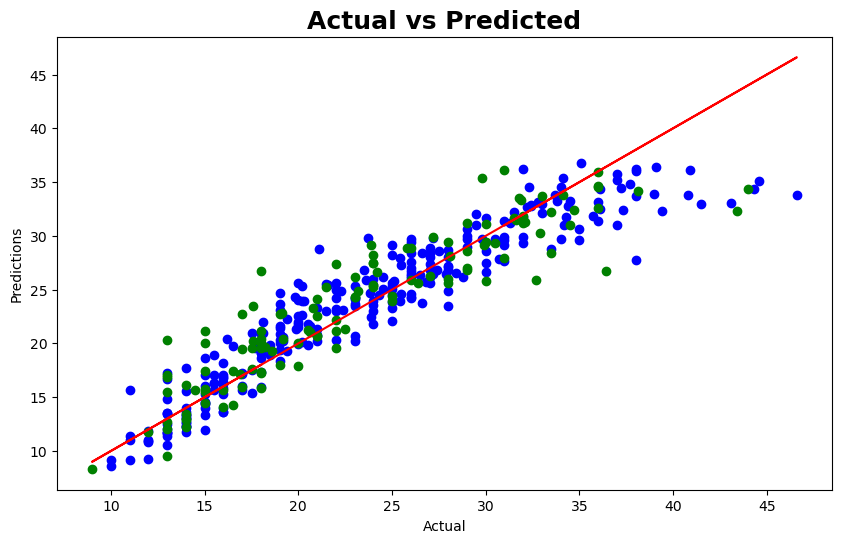

In [15]:
def model_factory():
    r1 = SVR()
    r2 = SVR(kernel='linear')
    r3 = LinearRegression()
    
    return VotingRegressor(estimators=[
        ('r1', r1), 
        ('r2', r2),
        ('r3', r3)
    ])

test_model_fn(model_factory)